# Training and Evaluating Simple Regression Model

In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

### Generate data

In [2]:
import numpy.random as random

random.seed(150)

dates = pd.DataFrame({'score_date': pd.date_range('2016-01-01', '2016-12-31')})
dates['key'] = 1

ids = pd.DataFrame({'id': np.arange(0, 100)})
ids['key'] = 1

data = pd.merge(ids, dates).drop('key', axis=1)

data['x1'] = 23 * random.randn(data.shape[0]) + 500
data['x2'] = 59 * random.randn(data.shape[0]) + 235
data['x3'] = 73 * random.randn(data.shape[0]) + 793  # Noise feature.

data['y'] = 0.37*data['x1'] + 0.97*data['x2'] + 0.32*data['x2']**2 - 5.0*data['id']*0.2 + \
            np.cos(pd.to_datetime(data['score_date']).astype(int)*200)*20.0

nan_idx = np.random.randint(0, data.shape[0], size=100)  # Inject nan in x1.
data.loc[nan_idx, 'x1'] = np.nan

nan_idx = np.random.randint(0, data.shape[0], size=100)  # Inject nan in x2.
data.loc[nan_idx, 'x2'] = np.nan

In [3]:
data.head()

,id,score_date,x1,x2,x3,y
0,0,2016-01-01,494.678185,212.949976,829.392324,14880.912784
1,0,2016-01-02,508.984104,158.174242,744.755316,8365.032313
2,0,2016-01-03,508.240842,291.856424,680.169336,27720.701968
3,0,2016-01-04,513.023623,137.007911,767.888326,6325.554470
4,0,2016-01-05,503.823382,279.123602,812.656548,25402.890737


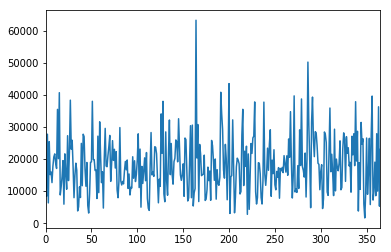

In [4]:
data['y'][data['id'] == 0].plot()
plt.show()

### Train Test Split 

In [5]:
from fklearn.preprocessing.splitting import space_time_split_dataset

train_start = '2016-01-01'
train_end = '2016-06-30'
holdout_end = '2016-12-31'

split_fn = space_time_split_dataset(
    train_start_date=train_start,
    train_end_date=train_end,
    holdout_end_date=holdout_end,
    split_seed=50,
    space_holdout_percentage=.05,
    space_column='id',
    time_column='score_date',
)

In [6]:
train_set, intime_outspace_hdout, outime_inspace_hdout, outime_outspace_hdout = split_fn(data)

train_set.shape, intime_outspace_hdout.shape, outime_inspace_hdout.shape, outime_outspace_hdout.shape

((17195, 6), (905, 6), (18400, 6), (920, 6))

### Define learner function

In [7]:
FEATURES = ['x1', 'x2', 'x3']
TARGET = ['y']

In [8]:
from fklearn.training.imputation import imputer

my_imputer = imputer(columns_to_impute=FEATURES, impute_strategy='median')

In [37]:
from fklearn.training.transformation import standard_scaler

my_scaler = standard_scaler(columns_to_scale=FEATURES)

In [10]:
from fklearn.training.regression import xgb_regression_learner

my_model = xgb_regression_learner(
    features=['x1', 'x2', 'x3'],
    target='y',
    prediction_column='prediction',
    extra_params={'seed': 139, 'nthread': 8},
)

In [11]:
from fklearn.training.transformation import ecdfer

my_ecdefer = ecdfer(prediction_column='prediction', ecdf_column='prediction_ecdf')

In [12]:
from fklearn.training.pipeline import build_pipeline

my_learner = build_pipeline(my_imputer, my_scaler, my_model, my_ecdefer)

### Train

In [13]:
(prediction_function, _, logs) = my_learner(train_set)

In [14]:
logs

{'imputer': {'impute_strategy': 'median',
  'columns_to_impute': ['x1', 'x2', 'x3'],
  'training_proportion_of_nulls': {'x1': 0.002675196277987787,
   'x2': 0.0023844140738586797,
   'x3': 0.0},
  'statistics': array([499.92366097, 234.4110308 , 792.50378949]),
  'running_time': '0.031 s'},
 'standard_scaler': {'standard_scaler': {'copy': True,
   'with_mean': True,
   'with_std': True},
  'transformed_column': ['x1', 'x2', 'x3'],
  'running_time': '0.018 s'},
 'xgb_regression_learner': {'features': ['x1', 'x2', 'x3'],
  'target': 'y',
  'prediction_column': 'prediction',
  'package': 'xgboost',
  'package_version': '0.82',
  'parameters': {'seed': 139,
   'nthread': 8,
   'eta': 0.1,
   'objective': 'reg:linear',
   'num_estimators': 100},
  'feature_importance': {'x2': 2415, 'x3': 514, 'x1': 919},
  'training_samples': 17195,
  'running_time': '1.191 s'},
 'ecdfer': {'nobs': 17195,
  'prediction_column': 'prediction',
  'ascending': True,
  'transformed_column': ['prediction_ecdf'],


### Evaluate

In [15]:
from fklearn.validation.evaluators import combined_evaluators, mean_prediction_evaluator, r2_evaluator, mse_evaluator

my_evaluator = combined_evaluators(
    evaluators=[
        mean_prediction_evaluator(prediction_column='prediction'),
        r2_evaluator(prediction_column='prediction', target_column='y'),
        mse_evaluator(prediction_column='prediction', target_column='y'),
    ]
)

In [16]:
test_predictions = prediction_function(outime_outspace_hdout)

my_evaluator(test_predictions)

{'mean_evaluator__prediction': 18914.416,
 'r2_evaluator__y': 0.9906295827453058,
 'mse_evaluator__y': 673677.8680663708}

### Run K-Fold Cross Validation

In [45]:
from fklearn.validation.validator import validator
from fklearn.metrics.pd_extractors import extract, evaluator_extractor

In [18]:
from fklearn.validation.splitters import k_fold_splitter

my_split_fn = k_fold_splitter(n_splits=2, random_state=42)

cv_results = validator(train_set, split_fn=my_split_fn, train_fn=my_learner, eval_fn=my_evaluator)

In [19]:
extract(cv_results['validator_log'], evaluator_extractor(evaluator_name='r2_evaluator__y'))

,r2_evaluator__y,fold_num,train_size,test_size
0,0.995754,0,8597,8598
0,0.996796,1,8598,8597


### Run Inverse Learning Curve Validation

In [20]:
from fklearn.validation.splitters import reverse_time_learning_curve_splitter

sc_split_fn = reverse_time_learning_curve_splitter(
    training_time_limit=train_end,
    time_column='score_date', 
    freq='W',
    min_samples=500,
)

lc_results = validator(train_set, split_fn=sc_split_fn, train_fn=my_learner, eval_fn=my_evaluator)

In [21]:
extract(lc_results['validator_log'], evaluator_extractor(evaluator_name='r2_evaluator__y'))

,r2_evaluator__y,fold_num,train_start,train_end,train_size,test_start,test_end,test_size
0,0.992036,0,2016-06-19,2016-06-26,760,2016-06-27,2016-06-29,285
0,0.999510,1,2016-06-12,2016-06-26,1425,2016-06-27,2016-06-29,285
0,0.999422,2,2016-06-05,2016-06-26,2090,2016-06-27,2016-06-29,285
0,0.999832,3,2016-05-29,2016-06-26,2755,2016-06-27,2016-06-29,285
0,0.999643,4,2016-05-22,2016-06-26,3420,2016-06-27,2016-06-29,285
0,0.999692,5,2016-05-15,2016-06-26,4085,2016-06-27,2016-06-29,285
0,0.999651,6,2016-05-08,2016-06-26,4750,2016-06-27,2016-06-29,285
0,0.999730,7,2016-05-01,2016-06-26,5415,2016-06-27,2016-06-29,285
0,0.999647,8,2016-04-24,2016-06-26,6080,2016-06-27,2016-06-29,285
0,0.999898,9,2016-04-17,2016-06-26,6745,2016-06-27,2016-06-29,285


### Run Stability Curve

In [22]:
from fklearn.validation.splitters import stability_curve_time_splitter

sc_split_fn = stability_curve_time_splitter(
    training_time_limit='2016-06-01',
    time_column='score_date',
    freq='M',
    min_samples=1000,
)

sc_results = validator(data, split_fn=sc_split_fn, train_fn=my_learner, eval_fn=my_evaluator)

In [23]:
extract(sc_results['validator_log'], evaluator_extractor(evaluator_name='r2_evaluator__y'))

,r2_evaluator__y,fold_num,train_start,train_end,train_size,test_start,test_end,test_size
0,0.998124,0,2016-01-01,2016-06-01,15300,2016-06-02,2016-06-30,2900
0,0.993554,0,2016-01-01,2016-06-01,15300,2016-07-01,2016-07-31,3100
0,0.998540,0,2016-01-01,2016-06-01,15300,2016-08-01,2016-08-31,3100
0,0.997695,0,2016-01-01,2016-06-01,15300,2016-09-01,2016-09-30,3000
0,0.995735,0,2016-01-01,2016-06-01,15300,2016-10-01,2016-10-31,3100
0,0.997235,0,2016-01-01,2016-06-01,15300,2016-11-01,2016-11-30,3000
0,0.998376,0,2016-01-01,2016-06-01,15300,2016-12-01,2016-12-31,3100


### Run Forward Stability Curve

In [24]:
from datetime import timedelta
from fklearn.validation.splitters import forward_stability_curve_time_splitter

fw_split_fn = forward_stability_curve_time_splitter(
    training_time_start='2016-01-01',
    training_time_end='2016-03-01',
    holdout_gap=timedelta(days=30),
    holdout_size=timedelta(days=30),
    step=timedelta(days=30),
    time_column='score_date',
)

fw_sc_results = validator(data, split_fn=fw_split_fn, train_fn=my_learner, eval_fn=my_evaluator)

In [25]:
extract(fw_sc_results['validator_log'], evaluator_extractor(evaluator_name='r2_evaluator__y'))

,r2_evaluator__y,fold_num,train_start,train_end,train_size,test_start,test_end,test_size
0,0.995640,0,2016-01-01,2016-02-29,6000,2016-03-31,2016-04-29,3000
0,0.992730,1,2016-01-31,2016-03-30,6000,2016-04-30,2016-05-29,3000
0,0.998711,2,2016-03-01,2016-04-29,6000,2016-05-30,2016-06-28,3000
0,0.992840,3,2016-03-31,2016-05-29,6000,2016-06-29,2016-07-28,3000
0,0.996390,4,2016-04-30,2016-06-28,6000,2016-07-29,2016-08-27,3000
0,0.996138,5,2016-05-30,2016-07-28,6000,2016-08-28,2016-09-26,3000
0,0.994155,6,2016-06-29,2016-08-27,6000,2016-09-27,2016-10-26,3000
0,0.997055,7,2016-07-29,2016-09-26,6000,2016-10-27,2016-11-25,3000
0,0.998399,8,2016-08-28,2016-10-26,6000,2016-11-26,2016-12-25,3000


### Run Spatial Learning Curve

In [26]:
from fklearn.validation.splitters import spatial_learning_curve_splitter

spatial_split_fn = spatial_learning_curve_splitter(
    train_percentages=np.linspace(0.1, 1, 10),
    space_column='id',
    time_column='score_date',
    training_limit='2016-06-01',
    holdout_gap=timedelta(days=180),
    random_state=0,    
)

spatial_lc_results = validator(data, split_fn=spatial_split_fn, train_fn=my_learner, eval_fn=my_evaluator)

In [27]:
extract(spatial_lc_results['validator_log'], evaluator_extractor(evaluator_name='r2_evaluator__y'))

,r2_evaluator__y,fold_num,train_start,train_end,train_size,test_start,test_end,test_size,percentage
0,0.994729,0,2016-01-01,2016-06-01,1530,2016-11-29,2016-12-31,3300,0.1
0,0.990840,1,2016-01-01,2016-06-01,3060,2016-11-29,2016-12-31,3300,0.2
0,0.997053,2,2016-01-01,2016-06-01,4590,2016-11-29,2016-12-31,3300,0.3
0,0.994885,3,2016-01-01,2016-06-01,6120,2016-11-29,2016-12-31,3300,0.4
0,0.996923,4,2016-01-01,2016-06-01,7650,2016-11-29,2016-12-31,3300,0.5
0,0.997560,5,2016-01-01,2016-06-01,9180,2016-11-29,2016-12-31,3300,0.6
0,0.998197,6,2016-01-01,2016-06-01,10710,2016-11-29,2016-12-31,3300,0.7
0,0.998720,7,2016-01-01,2016-06-01,12240,2016-11-29,2016-12-31,3300,0.8
0,0.997620,8,2016-01-01,2016-06-01,13770,2016-11-29,2016-12-31,3300,0.9
0,0.998228,9,2016-01-01,2016-06-01,15300,2016-11-29,2016-12-31,3300,1.0


### Feature Selection

In [28]:
from toolz import curry
from fklearn.tuning.selectors import feature_importance_backward_selection

# There might be columns that are features but are also auxiliary for evaluation, add them on the auxiliary list.
AUXILIARY_COLUMNS = list(set(train_set.columns) - set(FEATURES))

base_common_extractor = evaluator_extractor(evaluator_name='r2_evaluator__y')

@curry
def selector_pipeline(train_set, features):
    pipeline = build_pipeline(
        imputer(columns_to_impute=features, impute_strategy='median'),
        standard_scaler(columns_to_scale=features),
        xgb_regression_learner(
            features=features, 
            target='y', 
            prediction_column='prediction', 
            extra_params={'seed': 139, 'nthread': 8}
        ),
        ecdfer(prediction_column='prediction', ecdf_column='prediction_ecdf'),
    )
    return pipeline(train_set)

logs_fibs = feature_importance_backward_selection(
    train_set,
    selector_pipeline,
    FEATURES,
    my_split_fn,
    my_evaluator,
    base_common_extractor,
    metric_name='y',
    num_removed_by_step=1,
    threshold=0.0001,
    early_stop=100,
    iter_limit=3,
    min_remaining_features=1,
)

logs_fibs

[{'train_log': [{'imputer': {'impute_strategy': 'median',
     'columns_to_impute': ['x2'],
     'training_proportion_of_nulls': {'x2': 0.0018611143422123998},
     'statistics': array([234.52197656]),
     'running_time': '0.012 s'},
    'standard_scaler': {'standard_scaler': {'copy': True,
      'with_mean': True,
      'with_std': True},
     'transformed_column': ['x2'],
     'running_time': '0.009 s'},
    'xgb_regression_learner': {'features': ['x2'],
     'target': 'y',
     'prediction_column': 'prediction',
     'package': 'xgboost',
     'package_version': '0.82',
     'parameters': {'seed': 139,
      'nthread': 8,
      'eta': 0.1,
      'objective': 'reg:linear',
      'num_estimators': 100},
     'feature_importance': {'x2': 2833},
     'training_samples': 8597,
     'running_time': '0.447 s'},
    'ecdfer': {'nobs': 8597,
     'prediction_column': 'prediction',
     'ascending': True,
     'transformed_column': ['prediction_ecdf'],
     'running_time': '0.003 s'},
    '_

### Quick showing on how to get best features from selection logs

In [29]:
from fklearn.tuning.samplers import get_used_features, get_avg_metric_from_extractor, order_feature_importance_avg_from_logs

features = list(map(lambda x: get_used_features(x), logs_fibs))
auc = list(map(lambda x: get_avg_metric_from_extractor(x, base_common_extractor, 'r2_evaluator__y'), logs_fibs))

sorted(zip(features, auc), reverse=True, key=lambda x: x[1])[0]

(['x2'], 0.997040504359713)

### Interpretability: SHAP

In [38]:
import shap

shap.initjs()

In [39]:
holdout = pd.concat((intime_outspace_hdout, outime_inspace_hdout, outime_outspace_hdout))

In [40]:
preds = prediction_function(holdout, apply_shap=True)

In [41]:
shap_values = np.vstack(preds['shap_values'])

shap_expected_value = preds.shap_expected_value.iloc[0]

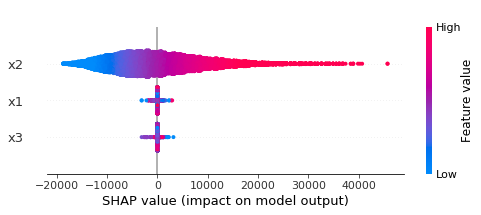

In [42]:
shap.summary_plot(shap_values, preds[FEATURES])

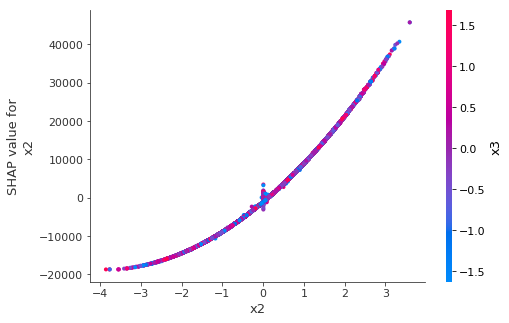

In [43]:
shap.dependence_plot('x2', shap_values, preds[FEATURES])

In [44]:
shap.force_plot(shap_expected_value, shap_values[0, :], preds[FEATURES].iloc[0, :])